<a href="https://colab.research.google.com/github/suhacker1/igvc-software/blob/multiclass_segmentation/IGVC_Full_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Restart runtime after running once

# Library for pretrained segmentation models fo PyTorch
!pip install segmentation-models-pytorch==0.1.0

# Catalyst library
!pip install -U catalyst

     |████████████████████████████████| 51kB 1.9MB/s 
     |████████████████████████████████| 61kB 3.8MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=8796ea1a7273a0e5773a1176fc77412d6e94d706501116a0b6b3b6a652bd2656
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=a01f8eea99b45da3bde07c107bd2091465f2c19ede5f06747514acbb691aa8b0
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch
     |████████████████████████████████| 389kB 3.4MB/s 
     |████████████████████████████████| 2.1MB 38.6MB/s 
     |████████████████████████████████| 204kB 36.0MB/s 
     |████████████████████████████████| 460kB 41.2MB/s 
     |████████████████████████████████| 71kB 9.8

In [0]:
# Dependencies

# Handles data 
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from operator import itemgetter

# Torch utilities 
from typing import List
from pathlib import Path
from torch.utils.data import Dataset
import torch

# Data Loader utilities 
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

# Model building and training 
import segmentation_models_pytorch as smp
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss
from torch import optim
from catalyst import utils

from catalyst.contrib.nn import RAdam, Lookahead
from catalyst.dl import SupervisedRunner

from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, AccuracyCallback, MulticlassDiceMetricCallback

In [0]:
# Sets a seed for better reproducibility 
SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

In [0]:
# Defines and establishes a dataset class
class SegmentationDataset(Dataset): 
    def __init__(
        self,
        image_arr_path,
        mask_arr_path,
    ) -> None:
        self.images = np.load(image_arr_path)
        self.masks = np.load(mask_arr_path)

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image = self.images[idx]
        image = np.swapaxes(image, 2, 0)
        image = np.swapaxes(image, 2, 1)
        image = torch.from_numpy(image).float()
        result = {"image": image}
        
        if self.masks is not None:
            mask = self.masks[idx]
            mask = np.swapaxes(mask, 2, 0)
            mask = np.swapaxes(mask, 2, 1)
            mask = torch.from_numpy(mask).float()
            result["mask"] = mask
        return result

In [0]:
# Loading once to enable visualizion prior to model training 
dset = SegmentationDataset(image_arr_path="/content/drive/My Drive/RoboJackets/Split_Data/train_images.npy", mask_arr_path="/content/drive/My Drive/RoboJackets/Split_Data/train_masks.npy")

In [0]:
# Show sizes of the image and mask 
out = dset[0]
out["image"].shape, out["mask"].shape, len(dset)

(torch.Size([3, 480, 640]), torch.Size([1, 480, 640]), 592)

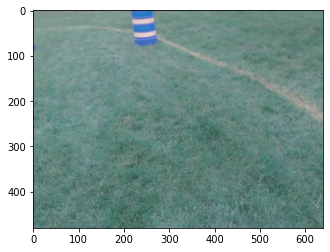

In [0]:
# Show an image 
show_image = np.asarray(dset[40]['image'])
show_image = np.swapaxes(show_image, 2, 0)
show_image = np.swapaxes(show_image, 1, 0)
show_image = show_image.astype(np.uint8)
np.shape(show_image)
plt.imshow(show_image)

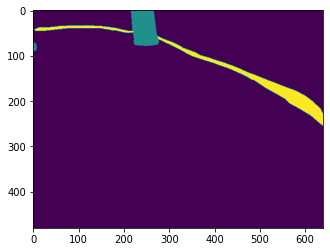

In [0]:
# Show associated mask 

show_mask = np.squeeze(dset[40]['mask'])
plt.imshow(show_mask)

In [0]:
# Set up transfer learning system 
	
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

# ACTIVATION = 'softmax'
ACTIVATION = None

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=3, 
    activation=ACTIVATION,
)

# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


In [0]:
# Define loaders 

def get_loaders(
    images: List[Path],
    masks: List[Path],
    image_arr_path: str,
    mask_arr_path: str,
    random_state: int,
    valid_size: float = 0.1,
    batch_size: int = 12,
    num_workers: int = 4,
    # train_transforms_fn = None,
    # valid_transforms_fn = None,
    ) -> dict:

    indices = np.arange(len(images))

    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    #print(np_images.shape, np_masks.shape)
    #print(train_indices)

    train_dataset = SegmentationDataset(image_arr_path, mask_arr_path)
    train_dataset.images = np_images[train_indices]
    train_dataset.masks = np_masks[train_indices]
    #print(len(train_dataset))
    #print(train_dataset.images.shape)
    #print(train_dataset.masks.shape)

    valid_dataset = SegmentationDataset(image_arr_path, mask_arr_path)
    valid_dataset.images = np_images[valid_indices]
    valid_dataset.masks = np_masks[valid_indices]
    #print(len(valid_dataset))
    #print(valid_dataset.images.shape)
    #print(valid_dataset.masks.shape)


    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=False,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=False,
    )

    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [0]:
# Get loaders  
loaders = get_loaders(
    images=np.load("/content/drive/My Drive/RoboJackets/Split_Data/train_images.npy"),
    masks=np.load("/content/drive/My Drive/RoboJackets/Split_Data/train_masks.npy"),
    image_arr_path="/content/drive/My Drive/RoboJackets/Split_Data/train_images.npy",
    mask_arr_path="/content/drive/My Drive/RoboJackets/Split_Data/train_masks.npy",
    random_state=420,
    valid_size=0.1,
    batch_size=3,
    num_workers=2,
)

(592, 480, 640, 3) (592, 480, 640, 1)
[412  85 558 199 435  91 212  43  47 245 400 480 500 347 337 202 142  64
  45 455 149  70 173 384 219 227 176 120 208 572  80 555 263 420 378  11
  40  36  69 254 130 410 554 121 548  84 411 195  49 427  12 503 339 128
 297  82  61 445 491 273 467 260 537 164 391  48 562  65  41 541 213 580
 233 413 416  90   0 285 458 497 311 426 526 472 255 259 116 134 204 579
 186 281 225 383 459  25 545  95 470  32 529 156  44 333 162 181 372 544
 494 550 531 387 161 557 179 473 271 356  13 180 570 417 286 177 381 140
 106 457 553 418 581 250 589 137 210 117 315 546 486 346 460 144 159 287
 340 290 489 216 275  19 135 355 207 229 215 591 523 436  83 112 167 328
 133 113 319 214  56  86 364 584 336 561 122 375  53 289 477 353 332 101
 222 320  34 183 343  79 404 123  18 453 362  87 228 155  67 291 165 351
 153 349  42  23 124 429 270 143  71 590 476  17 567  57 508 171 348 540
 514 444 421 578 395 365 475 110 262 312 466  78 484 350 288 274  29 236
 576 114 295 

In [0]:
# Helpful code taken from Joseph Chen 
#
#    Copyright 2019 Division of Medical Image Computing, German Cancer Research Center (DKFZ), Heidelberg, Germany
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.

import torch
from torch import nn
import numpy as np

def sum_tensor(inp, axes, keepdim=False):
    axes = np.unique(axes).astype(int)
    if keepdim:
        for ax in axes:
            inp = inp.sum(int(ax), keepdim=True)
    else:
        for ax in sorted(axes, reverse=True):
            inp = inp.sum(int(ax))
    return inp

def softmax_helper(x):
    rpt = [1 for _ in range(len(x.size()))]
    rpt[1] = x.size(1)
    x_max = x.max(1, keepdim=True)[0].repeat(*rpt)
    e_x = torch.exp(x - x_max)
    return e_x / e_x.sum(1, keepdim=True).repeat(*rpt)

class CrossentropyND(nn.CrossEntropyLoss):
    """
    Network has to have NO NONLINEARITY!
    """
    def forward(self, inp, target):
        target = target.long()
        num_classes = inp.size()[1]

        i0 = 1
        i1 = 2

        while i1 < len(inp.shape): # this is ugly but torch only allows to transpose two axes at once
            inp = inp.transpose(i0, i1)
            i0 += 1
            i1 += 1

        inp = inp.contiguous()
        inp = inp.view(-1, num_classes)

        target = target.view(-1,)

        return super(CrossentropyND, self).forward(inp, target)

def get_tp_fp_fn(net_output, gt, axes=None, mask=None, square=False):
    """
    net_output must be (b, c, x, y(, z)))
    gt must be a label map (shape (b, 1, x, y(, z)) OR shape (b, x, y(, z))) or one hot encoding (b, c, x, y(, z))
    if mask is provided it must have shape (b, 1, x, y(, z)))
    :param net_output:
    :param gt:
    :param axes:
    :param mask: mask must be 1 for valid pixels and 0 for invalid pixels
    :param square: if True then fp, tp and fn will be squared before summation
    :return:
    """
    if axes is None:
        axes = tuple(range(2, len(net_output.size())))

    shp_x = net_output.shape
    shp_y = gt.shape

    with torch.no_grad():
        if len(shp_x) != len(shp_y):
            gt = gt.view((shp_y[0], 1, *shp_y[1:]))

        if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
            # if this is the case then gt is probably already a one hot encoding
            y_onehot = gt
        else:
            gt = gt.long()
            y_onehot = torch.zeros(shp_x)
            if net_output.device.type == "cuda":
                y_onehot = y_onehot.cuda(net_output.device.index)
            y_onehot.scatter_(1, gt, 1)

    tp = net_output * y_onehot
    fp = net_output * (1 - y_onehot)
    fn = (1 - net_output) * y_onehot

    if mask is not None:
        tp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tp, dim=1)), dim=1)
        fp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fp, dim=1)), dim=1)
        fn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fn, dim=1)), dim=1)

    if square:
        tp = tp ** 2
        fp = fp ** 2
        fn = fn ** 2

    tp = sum_tensor(tp, axes, keepdim=False)
    fp = sum_tensor(fp, axes, keepdim=False)
    fn = sum_tensor(fn, axes, keepdim=False)

    return tp, fp, fn


class SoftDiceLoss(nn.Module):
    def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True,
                 smooth=1., square=False):
        super(SoftDiceLoss, self).__init__()

        self.square = square
        self.do_bg = do_bg
        self.batch_dice = batch_dice
        self.apply_nonlin = apply_nonlin
        self.smooth = smooth

    def forward(self, x, y, loss_mask=None):
        shp_x = x.shape

        if self.batch_dice:
            axes = [0] + list(range(2, len(shp_x)))
        else:
            axes = list(range(2, len(shp_x)))

        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        tp, fp, fn = get_tp_fp_fn(x, y, axes, loss_mask, self.square)

        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)

        if not self.do_bg:
            if self.batch_dice:
                dc = dc[1:]
            else:
                dc = dc[:, 1:]
        dc = dc.mean()

        return -dc


class DC_and_CE_loss(nn.Module):
    def __init__(self, soft_dice_kwargs, ce_kwargs, aggregate="sum"):
        super(DC_and_CE_loss, self).__init__()
        self.aggregate = aggregate
        self.ce = CrossentropyND(**ce_kwargs)
        self.dc = SoftDiceLoss(apply_nonlin=softmax_helper, **soft_dice_kwargs)

    def forward(self, net_output, target):
        dc_loss = self.dc(net_output, target)
        ce_loss = self.ce(net_output, target)
        if self.aggregate == "sum":
            result = ce_loss + dc_loss
        else:
            raise NotImplementedError("did not work") 
        return result

In [0]:
# Define loss criterion
criterion = {
    "CE": CrossentropyND(),
}

from torch.optim import AdamW

# Set up optimization 

learning_rate = 0.001 #0.001
encoder_learning_rate = 0.0005
encoder_weight_decay = 0.00003 #0.00003
optimizer_weight_decay = 0.0003 #0.0003
optim_factor = 0.25 #0.25 
optim_patience = 2 #2

optimizer = AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=optim_factor, patience=optim_patience)

num_epochs = 10
device = utils.get_device()

runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

In [0]:
callbacks = [
        CriterionCallback(
            input_key="mask",
            prefix="loss",
            criterion_key="CE"
        ),
        MulticlassDiceMetricCallback(input_key="mask")
        ]

In [0]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    logdir='content/full_model2', #this logdir must be changed with every new run
    num_epochs=num_epochs,
    
    main_metric="loss",
    minimize_metric=True,
    fp16=None,
    
    monitoring_params=None,
    
    verbose=True,
)

1/10 * Epoch (train): 100% 178/178 [01:41<00:00,  1.75it/s, _timer/_fps=0.821, _timer/batch_time=3.654, _timer/data_time=0.312, _timer/model_time=3.341, loss=0.053]
1/10 * Epoch (valid): 100% 20/20 [00:03<00:00,  6.29it/s, _timer/_fps=20.898, _timer/batch_time=0.144, _timer/data_time=0.012, _timer/model_time=0.131, loss=0.112]
[2020-03-20 03:33:53,038] 
1/10 * Epoch 1 (train): _timer/_fps=6.3847 | _timer/batch_time=0.5372 | _timer/data_time=0.3472 | _timer/model_time=0.1900 | dice_0=0.9635 | dice_1=0.0130 | dice_2=0.5910 | dice_mean=0.5225 | loss=0.2064
1/10 * Epoch 1 (valid): _timer/_fps=19.6645 | _timer/batch_time=0.1569 | _timer/data_time=0.0235 | _timer/model_time=0.1333 | dice_0=0.9769 | dice_1=0.5987 | dice_2=0.6905 | dice_mean=0.7554 | loss=0.1282
2/10 * Epoch (train): 100% 178/178 [01:22<00:00,  2.15it/s, _timer/_fps=7.819, _timer/batch_time=0.384, _timer/data_time=0.286, _timer/model_time=0.098, loss=0.044]
2/10 * Epoch (valid): 100% 20/20 [00:03<00:00,  5.98it/s, _timer/_fps=

In [0]:
# Test model on test dataset
test_data = SegmentationDataset("/content/drive/My Drive/RoboJackets/Split_Data/test_images.npy", "/content/drive/My Drive/RoboJackets/Split_Data/test_masks.npy")

In [0]:
infer_loader = DataLoader(
    test_data,
    batch_size=12,
    shuffle=False,
    num_workers=4
)

In [0]:
# get predictions on test data 
predictions = runner.predict_loader(
    model=model,
    loader=infer_loader,
    resume=f"content/full_model2/checkpoints/best.pth",
    verbose=False,
)

print(type(predictions))
print(predictions.shape)

=> loading checkpoint content/full_model2/checkpoints/best.pth
loaded checkpoint content/full_model2/checkpoints/best.pth (global epoch 4, epoch 4, stage train)
<class 'numpy.ndarray'>
(149, 3, 480, 640)


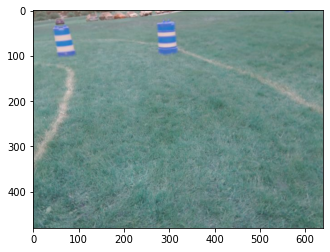

In [0]:
show_image = np.asarray(test_data[30]['image'])
show_image = np.swapaxes(show_image, 2, 0)
show_image = np.swapaxes(show_image, 1, 0)
show_image = show_image.astype(np.uint8)
np.shape(show_image)
plt.imshow(show_image)

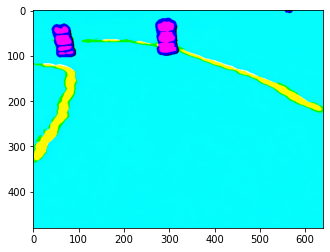

In [0]:
show_image = np.asarray(predictions[30])
show_image = np.swapaxes(show_image, 2, 0)
show_image = np.swapaxes(show_image, 1, 0)
show_image = show_image.astype(np.uint8)
np.shape(show_image)
plt.imshow(show_image)

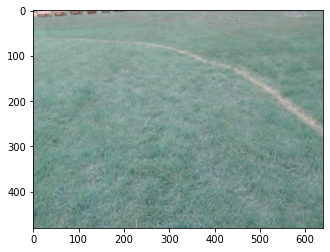

In [0]:
show_image = np.asarray(test_data[19]['image'])
show_image = np.swapaxes(show_image, 2, 0)
show_image = np.swapaxes(show_image, 1, 0)
show_image = show_image.astype(np.uint8)
np.shape(show_image)
plt.imshow(show_image)

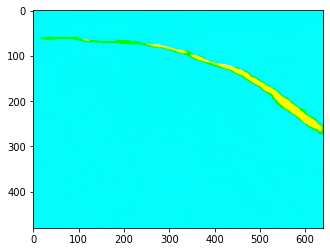

In [0]:
show_image = np.asarray(predictions[19])
show_image = np.swapaxes(show_image, 2, 0)
show_image = np.swapaxes(show_image, 1, 0)
show_image = show_image.astype(np.uint8)
np.shape(show_image)
plt.imshow(show_image)

In [0]:
%load_ext tensorboard
%tensorboard --logdir {'content/full_model2'}

In [0]:
LOG_DIR = './content/full_model2'

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'
    .format(LOG_DIR)
)
# Install
! npm install -g localtunnel

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6007 >> url.txt 2>&1 &')

# Get url
! cat url.txt


/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.0
updated 1 package in 2.06s


   ╭──────────────────────────────────────╮
   │                                      │
   │   Update available 5.7.1 → 6.14.3    │
   │      Run npm i -g npm to update      │
   │                                      │
   ╰──────────────────────────────────────╯



In [0]:
!npm i -g npm

/tools/node/bin/npm -> /tools/node/lib/node_modules/npm/bin/npm-cli.js
/tools/node/bin/npx -> /tools/node/lib/node_modules/npm/bin/npx-cli.js
+ npm@6.14.3
added 325 packages from 161 contributors, removed 423 packages and updated 59 packages in 14.469s
